<a href="https://colab.research.google.com/github/saikrishnanallavula/Final-year-project-Sai-Krishna-Nallavula/blob/main/EDA_TB_Detection_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory Data Analysis (EDA)**
## **Chest X-Ray: Normal vs Pathology (Pneumonia / TB)**

**Project:** Deep Learning vs Traditional ML for TB Detection  
**Primary dataset:** [Chest X-Ray Pneumonia (Kaggle)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) – folder-based (train/test/val, NORMAL/PNEUMONIA)  
**Alternative:** ChestX-ray8 – NIH (CSV-based)  
**Objectives:** Understand data distribution, class balance, and image characteristics to support model design and evaluation.

---
### **1. Setup and Configuration**

**Option A – Kaggle Chest X-Ray Pneumonia:** Set `USE_KAGGLE_DATASET = True` and run the download cell below (requires Kaggle API token in `~/.kaggle/kaggle.json`).  
**Option B – NIH CSV:** Set `USE_KAGGLE_DATASET = False` and provide `CSV_PATH` and `IMAGES_DIR`.

In [ ]:
# --- 1. Install Kaggle Library ---
!pip install -q kaggle

# --- 2. Upload kaggle.json ---
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

# --- 3. Configure API Credentials ---
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# --- 4. Download and Extract Dataset ---
# We use the official API command for this specific dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip quietly (-q) to avoid thousands of log lines
import zipfile
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

print("Dataset ready. Directory structure created: /chest_xray")

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset ready. Directory structure created: /chest_xray


---
### **2. Load Data (Kaggle folders or NIH CSV)**

**Kaggle:** Build a dataframe from `train/NORMAL`, `train/PNEUMONIA`, `test/`, `val/`.  
**NIH:** Load **Data_Entry_2017.csv** with columns such as `Image Index`, `Finding Labels`.

In [ ]:
import pandas as pd
from pathlib import Path
import os

def build_dataframe_from_folders(dataset_root: str) -> pd.DataFrame:
    """Build metadata from Kaggle folder structure: train/NORMAL, train/PNEUMONIA, etc."""
    root = Path(dataset_root)
    if not (root / "train").is_dir():
        raise FileNotFoundError(f"Expected folder with train/ under {dataset_root}. Run download cell first.")
    rows = []
    for split in ["train", "test", "val"]:
        split_dir = root / split
        if not split_dir.is_dir():
            continue
        for class_dir in split_dir.iterdir():
            if not class_dir.is_dir():
                continue
            label = class_dir.name
            binary = 0 if label.upper() == "NORMAL" else 1
            for f in class_dir.iterdir():
                if f.suffix.lower() in (".jpeg", ".jpg", ".png"):
                    rows.append({"path": str(f), "filename": f.name, "split": split, "label": label, "BinaryTarget": binary})
    return pd.DataFrame(rows)

if USE_KAGGLE_DATASET:
    df = build_dataframe_from_folders(DATASET_ROOT)
    label_col = None
    image_col = "path"
    neg_name, pos_name = "Normal", "Pneumonia"
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nSplit counts:")
    print(df["split"].value_counts().sort_index())
else:
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV not found at '{CSV_PATH}'. Use Kaggle dataset or provide CSV.")
    df = pd.read_csv(CSV_PATH)
    label_col = next((c for c in df.columns if "finding" in c.lower() or "label" in c.lower()), None)
    image_col = "Image Index" if "Image Index" in df.columns else df.columns[0]
    neg_name, pos_name = "TB-Negative", "TB-Positive"
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
df.head(10)

Shape: (5856, 5)
Columns: ['path', 'filename', 'split', 'label', 'BinaryTarget']

Split counts:
split
test      624
train    5216
val        16
Name: count, dtype: int64


,path,filename,split,label,BinaryTarget
0,chest_xray/train/NORMAL/NORMAL2-IM-1141-0001.jpeg,NORMAL2-IM-1141-0001.jpeg,train,NORMAL,0
1,chest_xray/train/NORMAL/NORMAL2-IM-1130-0001.jpeg,NORMAL2-IM-1130-0001.jpeg,train,NORMAL,0
2,chest_xray/train/NORMAL/NORMAL2-IM-1163-0001.jpeg,NORMAL2-IM-1163-0001.jpeg,train,NORMAL,0
3,chest_xray/train/NORMAL/NORMAL2-IM-0511-0001.jpeg,NORMAL2-IM-0511-0001.jpeg,train,NORMAL,0
4,chest_xray/train/NORMAL/IM-0732-0001.jpeg,IM-0732-0001.jpeg,train,NORMAL,0
5,chest_xray/train/NORMAL/NORMAL2-IM-0623-0001.jpeg,NORMAL2-IM-0623-0001.jpeg,train,NORMAL,0
6,chest_xray/train/NORMAL/IM-0598-0001.jpeg,IM-0598-0001.jpeg,train,NORMAL,0
7,chest_xray/train/NORMAL/NORMAL2-IM-0988-0001.jpeg,NORMAL2-IM-0988-0001.jpeg,train,NORMAL,0
8,chest_xray/train/NORMAL/IM-0135-0001.jpeg,IM-0135-0001.jpeg,train,NORMAL,0
9,chest_xray/train/NORMAL/NORMAL2-IM-1336-0001.jpeg,NORMAL2-IM-1336-0001.jpeg,train,NORMAL,0


---
### **3. Binary Target**

**Kaggle:** `BinaryTarget` is already set (0 = Normal, 1 = Pneumonia) from folder names.  
**NIH CSV:** We create it from the **Finding Labels** column (or one-hot column) using `TARGET_LABEL`.

In [ ]:
if USE_KAGGLE_DATASET:
    print("Binary target already set from folder labels (0=Normal, 1=Pneumonia).")
else:
    if label_col:
        def has_disease(labels):
            if pd.isna(labels):
                return 0
            return 1 if TARGET_LABEL.lower() in str(labels).lower() else 0
        df["BinaryTarget"] = df[label_col].apply(has_disease).astype(int)
        print(f"Using column '{label_col}' for target '{TARGET_LABEL}'.")
    else:
        possible = [c for c in df.columns if TARGET_LABEL.lower() in c.lower()]
        if possible:
            df["BinaryTarget"] = df[possible[0]].fillna(0).astype(int)
        else:
            for c in df.columns:
                if df[c].dtype in ["int64", "float64"] and set(df[c].dropna().unique()).issubset({0, 1}):
                    df["BinaryTarget"] = df[c].astype(int)
                    break
            else:
                raise ValueError("Could not create binary target. Check CSV and TARGET_LABEL.")
print("\nBinary target value counts:")
print(df["BinaryTarget"].value_counts().sort_index())

Binary target already set from folder labels (0=Normal, 1=Pneumonia).

Binary target value counts:
BinaryTarget
0    1583
1    4273
Name: count, dtype: int64


---
### **4. Class Distribution and Imbalance**

Understanding class balance is critical for choosing metrics (e.g. **recall** for rare TB-positive cases) and strategies (e.g. **class weights**, **oversampling**).

Normal: 1583
Pneumonia: 4273
Positive rate: 72.97%
Imbalance ratio (Neg:Pos): 0.4:1


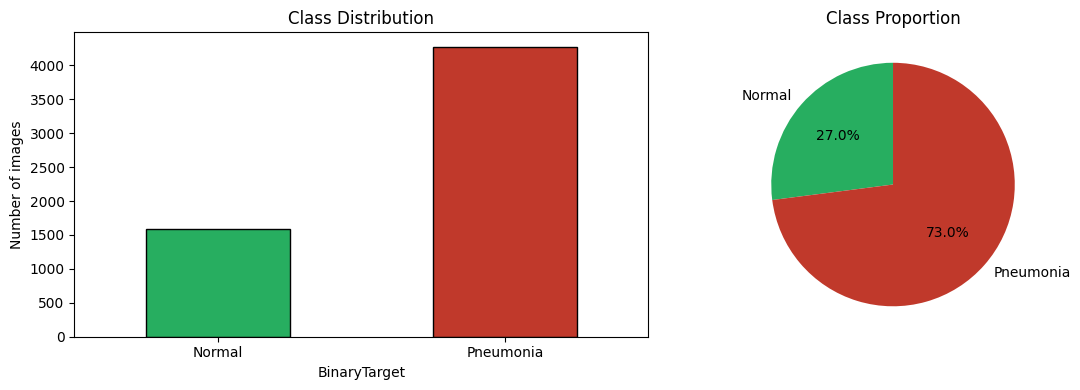

In [ ]:
counts = df["BinaryTarget"].value_counts().sort_index()
n_neg, n_pos = counts.get(0, 0), counts.get(1, 0)
print(f"{neg_name}: {n_neg}")
print(f"{pos_name}: {n_pos}")
print(f"Positive rate: {df['BinaryTarget'].mean():.2%}")
print(f"Imbalance ratio (Neg:Pos): {n_neg / max(n_pos, 1):.1f}:1")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
counts.plot(kind="bar", ax=axes[0], color=["#27ae60", "#c0392b"], edgecolor="black")
axes[0].set_xticklabels([neg_name, pos_name], rotation=0)
axes[0].set_ylabel("Number of images")
axes[0].set_title("Class Distribution")

axes[1].pie(counts, labels=[neg_name, pos_name], autopct="%1.1f%%",
            colors=["#27ae60", "#c0392b"], startangle=90)
axes[1].set_title("Class Proportion")
plt.tight_layout()
plt.show()

---
### **5. Distribution of Labels (or by Split for Kaggle)**

**NIH CSV:** Distribution of finding labels (multi-label).  
**Kaggle:** Distribution by split (train/test/val).

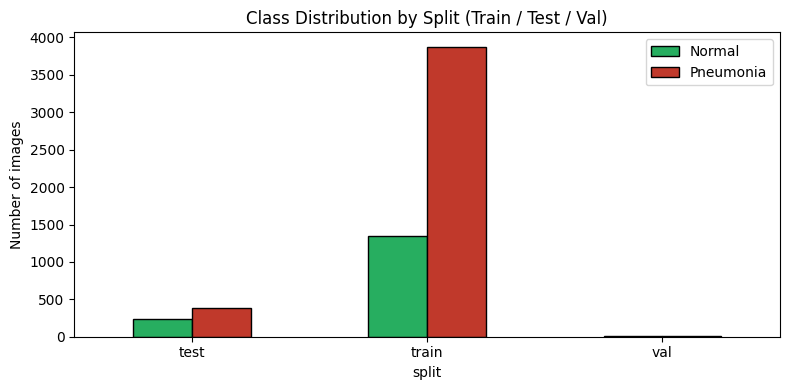

In [ ]:
if USE_KAGGLE_DATASET and "split" in df.columns:
    split_counts = df.groupby("split")["BinaryTarget"].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(8, 4))
    split_counts.plot(kind="bar", ax=ax, color=["#27ae60", "#c0392b"], edgecolor="black")
    ax.set_xticklabels(split_counts.index, rotation=0)
    ax.set_ylabel("Number of images")
    ax.set_title("Class Distribution by Split (Train / Test / Val)")
    ax.legend([neg_name, pos_name])
    plt.tight_layout()
    plt.show()
elif label_col and df[label_col].notna().any():
    all_findings = []
    for s in df[label_col].dropna().astype(str):
        for part in s.split("|"):
            part = part.strip()
            if part and "no finding" not in part.lower():
                all_findings.append(part)
    if all_findings:
        finding_counts = pd.Series(Counter(all_findings)).sort_values(ascending=False)
        print("Top 15 finding labels:")
        print(finding_counts.head(15))
        fig, ax = plt.subplots(figsize=(10, 6))
        finding_counts.head(15).plot(kind="barh", ax=ax, color="steelblue")
        ax.set_xlabel("Number of images")
        ax.set_title("Distribution of Finding Labels (top 15)")
        plt.tight_layout()
        plt.show()
else:
    print("No split or finding labels to plot.")

---
### **6. Missing Values and Data Quality**

In [ ]:
missing = df.isnull().sum()
if missing.any():
    print("Missing values per column:")
    print(missing[missing > 0])
else:
    print("No missing values in metadata.")
print("\nData types:")
print(df.dtypes)

No missing values in metadata.

Data types:
path            object
filename        object
split           object
label           object
BinaryTarget     int64
dtype: object


---
### **7. Image File Check and Sample Dimensions**

Verify that image paths exist and inspect image dimensions (relevant for **CNN input size**).

In [ ]:
path_col = "path" if "path" in df.columns else image_col
print(f"Path column: {path_col}")

if HAS_PIL:
    sample = df[path_col].head(10)
    found = 0
    sizes = []
    for p in sample:
        full = p if os.path.isabs(p) else os.path.join(IMAGES_DIR, p) if not USE_KAGGLE_DATASET else p
        if os.path.exists(full):
            found += 1
            try:
                img = Image.open(full)
                sizes.append(img.size)
            except Exception as e:
                print(f"Error loading: {e}")
    print(f"Found {found}/{len(sample)} sample files")
    if sizes:
        print(f"Sample dimensions: {sizes[0]} (W x H)")
else:
    print("PIL not available. pip install Pillow")

Path column: path
Found 10/10 sample files
Sample dimensions: (1824, 1090) (W x H)


---
### **8. Sample X-Ray Images by Class**

Visualise a few **TB-negative** and **TB-positive** (or pathology-positive) images to understand visual differences.

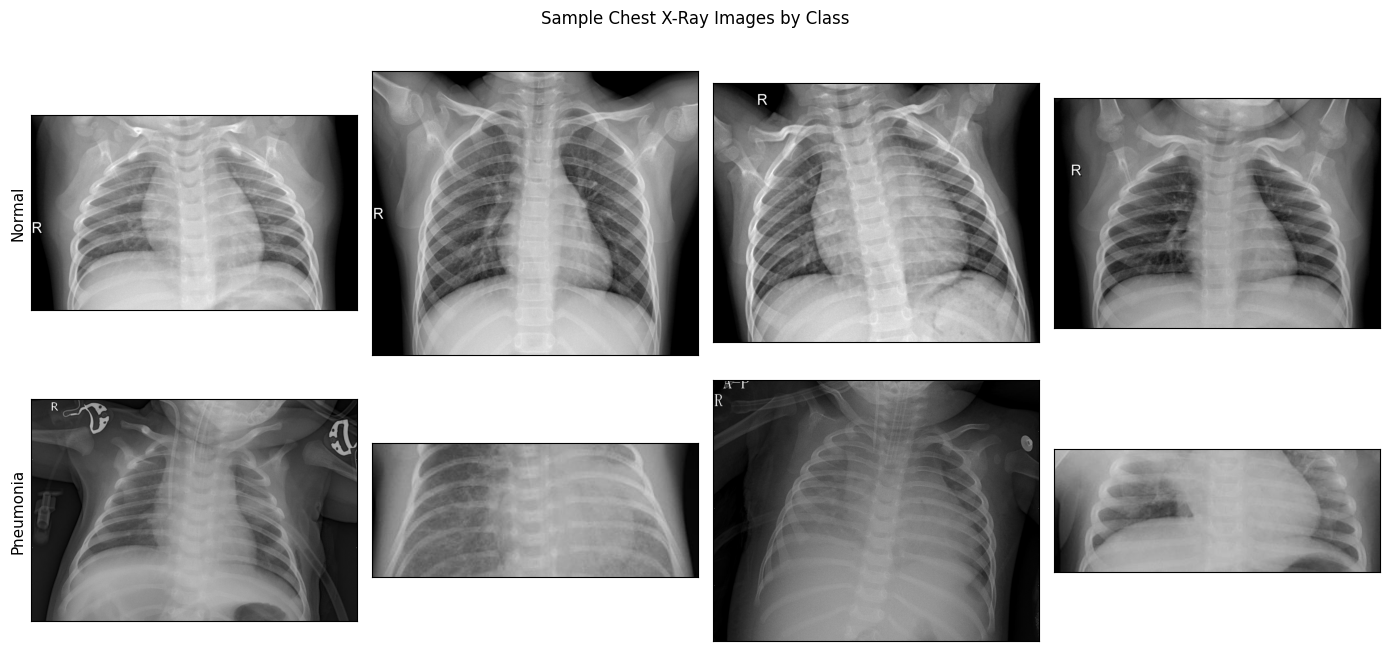

In [ ]:
if HAS_PIL and path_col in df.columns:
    pos_paths = df[df["BinaryTarget"] == 1][path_col].dropna().head(4).tolist()
    neg_paths = df[df["BinaryTarget"] == 0][path_col].dropna().head(4).tolist()
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    for i, (label, paths) in enumerate([(neg_name, neg_paths), (pos_name, pos_paths)]):
        for j, p in enumerate(paths):
            full = p if os.path.isabs(p) else os.path.join(IMAGES_DIR, p) if not USE_KAGGLE_DATASET else p
            ax = axes[i, j]
            if os.path.exists(full):
                try:
                    img = Image.open(full)
                    ax.imshow(img, cmap="gray")
                except Exception:
                    ax.text(0.5, 0.5, "Error", ha="center", va="center")
            else:
                ax.text(0.5, 0.5, "Not found", ha="center", va="center")
            ax.set_xticks([])
            ax.set_yticks([])
            if j == 0:
                ax.set_ylabel(label, fontsize=11)
    plt.suptitle("Sample Chest X-Ray Images by Class", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping sample images (missing path column or PIL).")

---
### **9. Train/Validation/Test Split**

**Kaggle:** Splits are already provided (`train`, `test`, `val`).  
**NIH CSV:** Use a **stratified split** (e.g. 70% train, 10% val, 20% test).

In [ ]:
if USE_KAGGLE_DATASET and "split" in df.columns:
    print("Using provided train / test / val splits:")
    for split_name in ["train", "test", "val"]:
        part = df[df["split"] == split_name]
        if len(part) > 0:
            print(f"  {split_name}: {len(part)} ({len(part)/len(df):.1%}) — Neg={(part['BinaryTarget']==0).sum()}, Pos={(part['BinaryTarget']==1).sum()}")
else:
    from sklearn.model_selection import train_test_split
    train_val, test = train_test_split(df, test_size=0.2, stratify=df["BinaryTarget"], random_state=42)
    train, val = train_test_split(train_val, test_size=0.125, stratify=train_val["BinaryTarget"], random_state=42)
    print("Suggested split (stratified):")
    print(f"  Train:  {len(train)} ({len(train)/len(df):.1%})")
    print(f"  Val:    {len(val)} ({len(val)/len(df):.1%})")
    print(f"  Test:   {len(test)} ({len(test)/len(df):.1%})")
    print("\nClass balance in each split:")
    for name, part in [("Train", train), ("Val", val), ("Test", test)]:
        print(f"  {name}: Neg={(part['BinaryTarget']==0).sum()}, Pos={(part['BinaryTarget']==1).sum()}")

Using provided train / test / val splits:
  train: 5216 (89.1%) — Neg=1341, Pos=3875
  test: 624 (10.7%) — Neg=234, Pos=390
  val: 16 (0.3%) — Neg=8, Pos=8


In [ ]:
Path("eda_output").mkdir(exist_ok=True)
df.to_csv("eda_output/metadata_with_binary_target.csv", index=False)
print("Processed metadata saved to eda_output/metadata_with_binary_target.csv")

Processed metadata saved to eda_output/metadata_with_binary_target.csv
